In [ ]:
#!pip install pandas numpy matplotlib scikit-learn

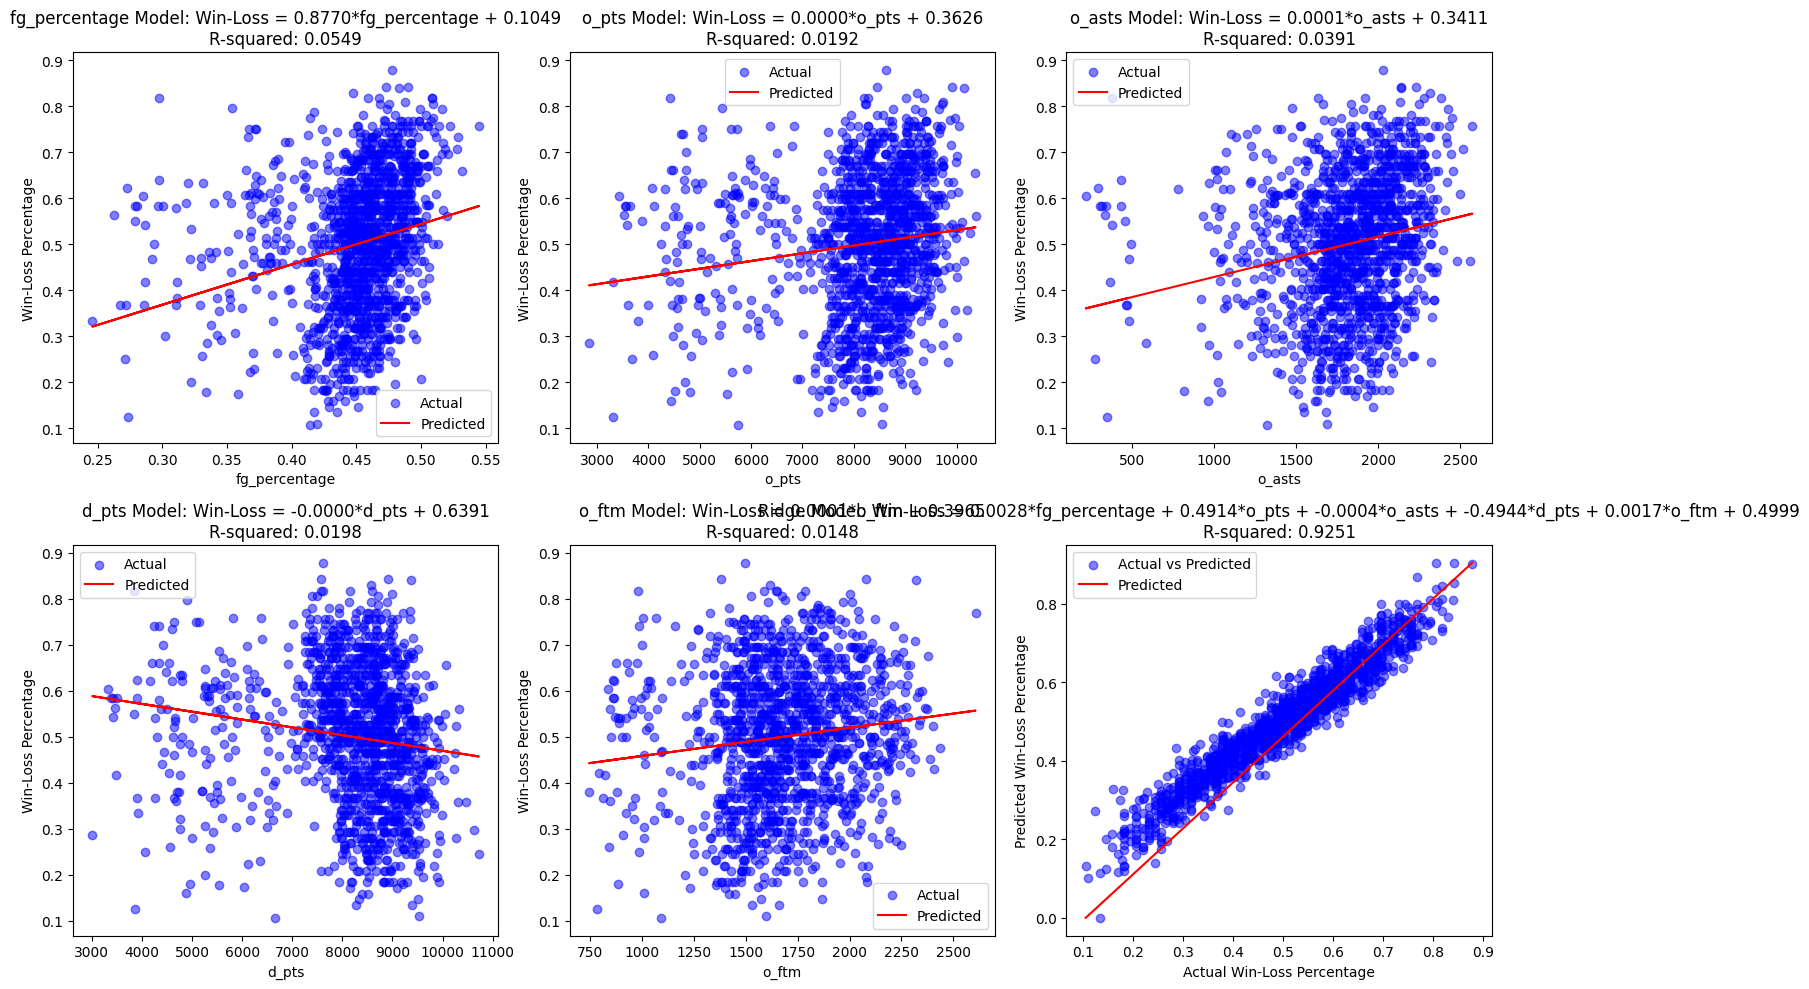

fg_percentage - R-squared: 0.05493272, MSE: 0.0211, Formula: fg_percentage Model: Win-Loss = 0.8770*fg_percentage + 0.1049
o_pts - R-squared: 0.01916566, MSE: 0.0219, Formula: o_pts Model: Win-Loss = 0.0000*o_pts + 0.3626
o_asts - R-squared: 0.03908770, MSE: 0.0215, Formula: o_asts Model: Win-Loss = 0.0001*o_asts + 0.3411
d_pts - R-squared: 0.01976012, MSE: 0.0219, Formula: d_pts Model: Win-Loss = -0.0000*d_pts + 0.6391
o_ftm - R-squared: 0.01477760, MSE: 0.0220, Formula: o_ftm Model: Win-Loss = 0.0001*o_ftm + 0.3965
ridge - R-squared: 0.92513576, MSE: 0.0017, Formula: Ridge Model: Win-Loss = 0.0028*fg_percentage + 0.4914*o_pts + -0.0004*o_asts + -0.4944*d_pts + 0.0017*o_ftm + 0.4999


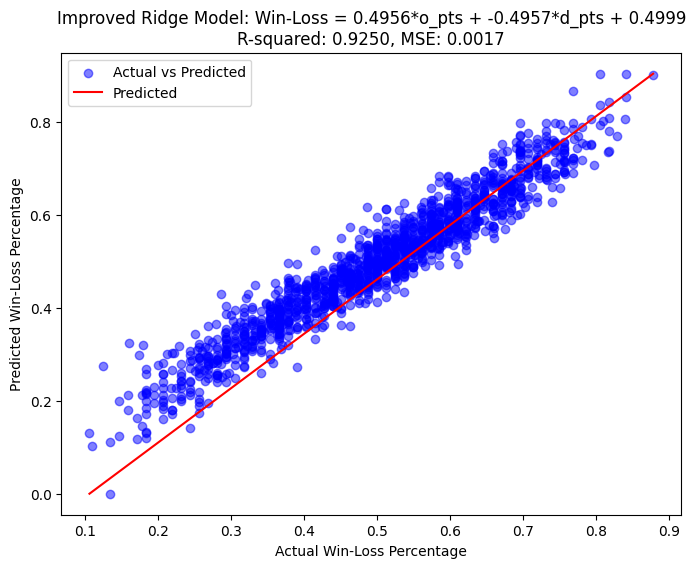

New Ridge model - R-squared: 0.92503191, MSE: 0.0017, Formula: Improved Ridge Model: Win-Loss = 0.4956*o_pts + -0.4957*d_pts + 0.4999


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

#load the data
data = pd.read_csv('basketball_teams_cleaned.csv')

#calculate field goal percentage and win-loss percentage
data['fg_percentage'] = data['o_fgm'] / data['o_fga']
data['win_loss_percentage'] = data['won'] / data['games']

#remove any infinite or Not a Number values
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

#define the five features and target variable
features = ['fg_percentage', 'o_pts', 'o_asts', 'd_pts', 'o_ftm']
y = data['win_loss_percentage']

#initialize the figure for plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

#dictionary to store models, metrics, and formulas
models = {}

#calculate, plot linear regression for each feature, and construct formulas
for i, feature in enumerate(features):
    X_feature = data[[feature]]
    lin_model = LinearRegression()
    lin_model.fit(X_feature, y)
    y_pred = lin_model.predict(X_feature)
    
    #store model, metrics, and formula
    coefficient = lin_model.coef_[0]
    intercept = lin_model.intercept_
    formula = f'{feature} Model: Win-Loss = {coefficient:.4f}*{feature} + {intercept:.4f}'
    models[feature] = {
        'model': lin_model,
        'r2': r2_score(y, y_pred),
        'mse': mean_squared_error(y, y_pred),
        'formula': formula
    }
    
    #plot scatterplot and regression line
    axs[i].scatter(X_feature, y, color='blue', alpha=0.5, label='Actual')
    axs[i].plot(X_feature, y_pred, color='red', label='Predicted')
    axs[i].set_title(f'{formula}\nR-squared: {models[feature]["r2"]:.4f}')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Win-Loss Percentage')
    axs[i].legend()

#prepare data for Ridge Regression
X = data[features]

#create Ridge regression model with standardization and cross-validation
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridgecv', RidgeCV(alphas=np.logspace(-6, 6, 13)))
])

#fit the Ridge model
ridge_pipeline.fit(X, y)

#predict and evaluate Ridge model
y_pred_ridge = ridge_pipeline.predict(X)
ridge_coefficients = ridge_pipeline.named_steps['ridgecv'].coef_
ridge_intercept = ridge_pipeline.named_steps['ridgecv'].intercept_
ridge_formula = ' + '.join([f'{coef:.4f}*{feat}' for coef, feat in zip(ridge_coefficients, features)])
ridge_formula = f'Ridge Model: Win-Loss = {ridge_formula} + {ridge_intercept:.4f}'
models['ridge'] = {
    'model': ridge_pipeline,
    'r2': r2_score(y, y_pred_ridge),
    'mse': mean_squared_error(y, y_pred_ridge),
    'formula': ridge_formula
}

#plot scatterplot for Ridge Regression model
axs[-1].scatter(y, y_pred_ridge, color='blue', alpha=0.5, label='Actual vs Predicted')
axs[-1].plot([min(y), max(y)], [min(y_pred_ridge), max(y_pred_ridge)], color='red', label='Predicted')
axs[-1].set_title(f"{ridge_formula}\nR-squared: {models['ridge']['r2']:.4f}")
axs[-1].set_xlabel('Actual Win-Loss Percentage')
axs[-1].set_ylabel('Predicted Win-Loss Percentage')
axs[-1].legend()

#display the plots
plt.tight_layout()
plt.show()

#output R-squared, MSE, and formula for all models
for feature, metrics in models.items():
    print(f"{feature} - R-squared: {metrics['r2']:.8f}, MSE: {metrics['mse']:.4f}, Formula: {metrics['formula']}")

#identify features with minimal impact (small coefficients)
#we will consider a threshold of 0.01 for coefficient magnitude
threshold = 0.01
features_to_keep = [feat for coef, feat in zip(ridge_coefficients, features) if abs(coef) >= threshold]

#prepare data with selected features
X_selected = data[features_to_keep]

#re-fit the Ridge model with selected features
ridge_pipeline_selected = Pipeline([
    ('scaler', StandardScaler()),
    ('ridgecv', RidgeCV(alphas=np.logspace(-6, 6, 13)))
])
ridge_pipeline_selected.fit(X_selected, y)

#predict and evaluate the new Ridge model
y_pred_ridge_selected = ridge_pipeline_selected.predict(X_selected)
r2_ridge_selected = r2_score(y, y_pred_ridge_selected)
mse_ridge_selected = mean_squared_error(y, y_pred_ridge_selected)

#new Ridge model formula
ridge_coefficients_selected = ridge_pipeline_selected.named_steps['ridgecv'].coef_
ridge_intercept_selected = ridge_pipeline_selected.named_steps['ridgecv'].intercept_
ridge_formula_selected = ' + '.join([f'{coef:.4f}*{feat}' for coef, feat in zip(ridge_coefficients_selected, features_to_keep)])
ridge_formula_selected = f'Improved Ridge Model: Win-Loss = {ridge_formula_selected} + {ridge_intercept_selected:.4f}'

#plot the new Ridge Regression model
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred_ridge_selected, color='blue', alpha=0.5, label='Actual vs Predicted')
plt.plot([min(y), max(y)], [min(y_pred_ridge_selected), max(y_pred_ridge_selected)], color='red', label='Predicted')
plt.title(f"{ridge_formula_selected}\nR-squared: {r2_ridge_selected:.4f}, MSE: {mse_ridge_selected:.4f}")
plt.xlabel('Actual Win-Loss Percentage')
plt.ylabel('Predicted Win-Loss Percentage')
plt.legend()
plt.show()

#print the new Ridge model's statistics
print(f"New Ridge model - R-squared: {r2_ridge_selected:.8f}, MSE: {mse_ridge_selected:.4f}, Formula: {ridge_formula_selected}")